# Natural Language Processing

In [42]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda:2


In [43]:
# torch.cuda.get_device_name(0)

In [44]:
torch.__version__

'1.13.1+cu117'

In [45]:
torchtext.__version__

'0.14.1'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [46]:
#uncomment this if you are not using our department puffer
# import os
# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'de'

train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [47]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [48]:
#let's take a look at one example of train
sample = next(iter(train))
sample

('Two young, White males are outside near many bushes.',
 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.')

In [49]:
train_size = len(list(iter(train)))
train_size

29001

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [50]:
train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [51]:
train_size = len(list(iter(train)))
train_size

20301

In [52]:
val_size = len(list(iter(val)))
val_size

5800

In [53]:
test_size = len(list(iter(test)))
test_size

2900

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [54]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [55]:
# python -m spacy download de_core_news_sm

from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

In [56]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  Two young, White males are outside near many bushes.
Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


A function to tokenize our input.

In [57]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [58]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [59]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [60]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[1891, 10, 4, 0, 4]

In [61]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'here'

In [62]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [63]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [64]:
#check unique vocabularies
len(mapping)

5174

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [65]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [66]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [67]:
for en, _, de in train_loader:
    break

In [68]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("German shape: ", de.shape)   # (seq len, batch_size)

English shape:  torch.Size([27, 64])
German shape:  torch.Size([24, 64])


## 5. Design the model

### Encoder

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [69]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src: [src len, batch size]
        #src len: [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                            src_len.to('cpu'), enforce_sorted=False)
        
        #packed_outputs contain all hidden states including padding guy
        #hidden contains the last hidden states of the non-padded guys
        packed_outputs, hidden = self.rnn(packed_embedded)
        #hidden: [n layers * num directions, batch size, hid dim]
        
        #convert packed_outputs to the guy that does not contain hidden states for padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs: [src len, batch size, hid dim * num directions]
        
        #take the last hidden states from backward and forward
        #hidden: (f, b, f, b)
        forward  = hidden[-2, :, :]  #[batch size, hid dim]
        backward = hidden[-1, :, :]  #[batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((forward, backward), dim = 1))) 
        #hidden: [batch size, hid dim]
        
        return outputs, hidden

### Attention

The attention used here is additive attention which is defined by:

$$e = v\text{tanh}(W_hh + W_ss + b)$$

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a `[batch size, source sentence length]` tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: `["hello", "how", "are", "you", "?", `<pad>`, `<pad>`]`, then the mask would be `[1, 1, 1, 1, 1, 0, 0]`.

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [70]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch size, src len, hid dim]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
        #energy = [batch size, src len, hid dim]
        
        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]
        
        #use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

Let's see how the masked_fill work, just so you have faith

In [71]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [83]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #Ct
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
        
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [1, batch size, hid dim]
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Putting them together (become Seq2Seq!)

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [84]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        #src: [src len, batch size]
        
        mask = (src == self.src_pad_idx).permute(1, 0)
        #mask: [batch size, src len]
        #we need to permute to make the mask same shape as attention...
        return mask

        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src: [src len, batch size]
        #src len: [batch size]
        #trg: [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim #define in decoder
        
        #because decoder decodes each step....let's create a list that gonna append the result to this guy
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #because decoder decodes each step....let's memorize the attention done in each step....
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #let's start!!!
        #1. encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs: [src len, batch size, hid dim * num directions]
        #hidden: [batch size, hid dim]
        
        #set the first input to the decoder
        input_ = trg[0,:]  #basically <sos>
        
        #create the mask for use in this step
        mask = self.create_mask(src)
        
        #2. for each of trg word
        for t in range(1, trg_len):

            #3. decode (hidden is always carry forward)
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output:   [batch size, output_dim]
            #hidden:   [batch size, hid_dim]
            #attention::[batch size, src len]  ==> how each of src token is important to input_ 
            
            #4. append the results to outputs and attentions
            outputs[t] = output
            attentions[t] = attention
            
            #5. get the result, using argmax
            top1 = output.argmax(1)  #find the maximum index of dimension 1, which is output_dim
            
            #6. based on the teacher forcing ratio, 
            teacher_force_or_not = random.random() < teacher_forcing_ratio
                    #if teacher forcing, next input is the next trg
                    #if no teacher forcing, the next input is the argmax guy...
            input_ = trg[t] if teacher_force_or_not else top1  #autoregressive
            
        return outputs, attentions #outputs for predicting the word, attentions to see which word is important
        
        

## 6. Training

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [85]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [86]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(5174, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(6433, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=6433, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [87]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1324544
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
1646848
1966080
786432
  1536
  1536
11527936
  6433
______
20939553


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [88]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

The training is very similar to part 1.

In [89]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [90]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [91]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [92]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [93]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 56s
	Train Loss: 4.901 | Train PPL: 134.400
	 Val. Loss: 4.788 |  Val. PPL: 120.037
Epoch: 02 | Time: 0m 58s
	Train Loss: 3.767 | Train PPL:  43.264
	 Val. Loss: 3.772 |  Val. PPL:  43.471
Epoch: 03 | Time: 0m 58s
	Train Loss: 3.059 | Train PPL:  21.313
	 Val. Loss: 3.295 |  Val. PPL:  26.974
Epoch: 04 | Time: 0m 57s
	Train Loss: 2.635 | Train PPL:  13.946
	 Val. Loss: 2.946 |  Val. PPL:  19.033
Epoch: 05 | Time: 0m 56s
	Train Loss: 2.316 | Train PPL:  10.131
	 Val. Loss: 2.665 |  Val. PPL:  14.363
Epoch: 06 | Time: 0m 57s
	Train Loss: 2.041 | Train PPL:   7.697
	 Val. Loss: 2.512 |  Val. PPL:  12.335
Epoch: 07 | Time: 0m 57s
	Train Loss: 1.864 | Train PPL:   6.449
	 Val. Loss: 2.316 |  Val. PPL:  10.140
Epoch: 08 | Time: 0m 57s
	Train Loss: 1.716 | Train PPL:   5.564
	 Val. Loss: 2.172 |  Val. PPL:   8.772
Epoch: 09 | Time: 0m 57s
	Train Loss: 1.587 | Train PPL:   4.890
	 Val. Loss: 2.073 |  Val. PPL:   7.946
Epoch: 10 | Time: 0m 56s
	Train Loss: 1.456 | Train PPL

Text(0, 0.5, 'loss')

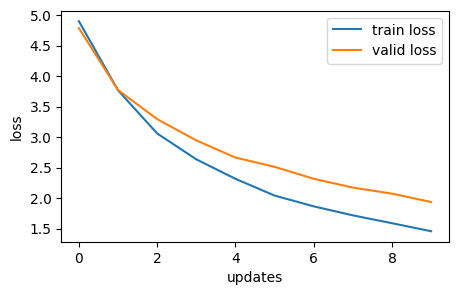

In [94]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [95]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.931 | Test PPL:   6.900 |


In [96]:
model

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(5174, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(6433, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=6433, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## 7. Test on some random news

In [97]:
sample[0]

'Two young, White males are outside near many bushes.'

In [98]:
sample[1]

'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'

In [99]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,   19,   25,   15, 1069,  842,   17,   56,   84,  331, 1623,    5,
           3], device='cuda:2')

In [100]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,   21,   83,  262,   32,   89,   22,   91,    7,   16,  115,    0,
        2893,    4,    3], device='cuda:2')

In [101]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [102]:
trg_text = trg_text.reshape(-1, 1)

In [103]:
src_text.shape, trg_text.shape

(torch.Size([13, 1]), torch.Size([15, 1]))

In [104]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [105]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [106]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([15, 1, 6433])

Since batch size is 1, we just take off that dimension

In [107]:
output = output.squeeze(1)

In [108]:
output.shape

torch.Size([15, 6433])

We shall remove the first token since it's zeroes anyway

In [109]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([14, 6433])

Then we just take the top token with highest probabilities

In [110]:
output_max = output.argmax(1) #returns max indices

In [111]:
output_max

tensor([  21,   83,  262,   32,   89,  139,   89, 2893, 2893, 2893,    4,    3,
           3,    3], device='cuda:2')

Get the mapping of the target language

In [112]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [113]:
for token in output_max:
    print(mapping[token.item()])

Zwei
junge
weiße
Männer
sind
draußen
sind
Büsche
Büsche
Büsche
.
<eos>
<eos>
<eos>


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [114]:
attentions.shape

torch.Size([15, 1, 13])

In [115]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'Two',
 'young',
 ',',
 'White',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'bushes',
 '.',
 '<eos>']

In [116]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'Zwei',
 'junge',
 'weiße',
 'Männer',
 'sind',
 'draußen',
 'sind',
 'Büsche',
 'Büsche',
 'Büsche',
 '.',
 '<eos>',
 '<eos>',
 '<eos>']

In [117]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/tmp/ipykernel_15938/59549304.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_15938/59549304.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


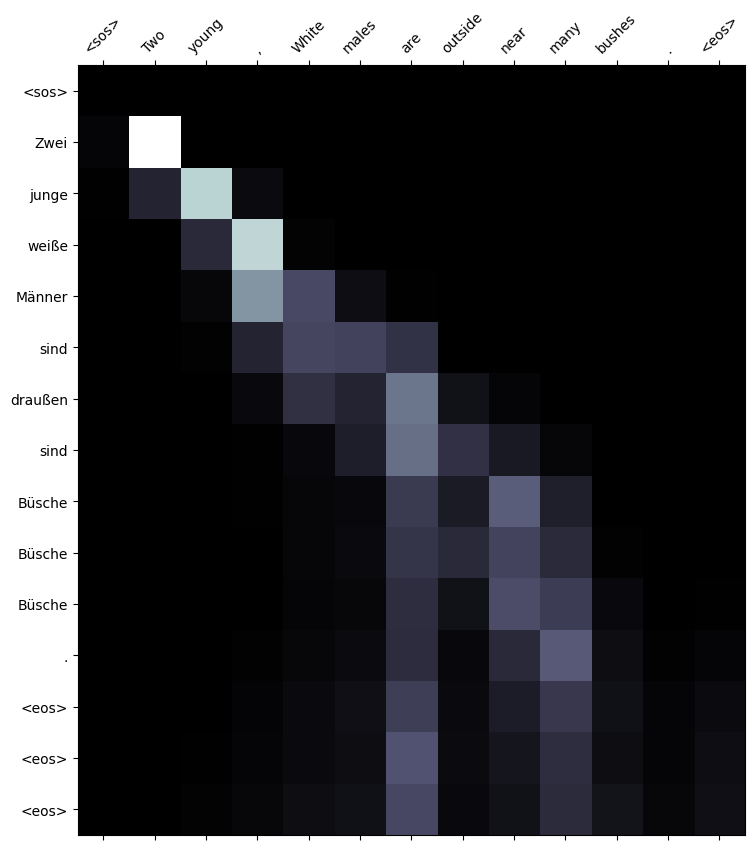

In [118]:
display_attention(src_tokens, trg_tokens, attentions)

## Conclusion

Nice!  We get the similar perplexity but with much faster computations, thanks to packed sequences and masking.   We also can see attention by our eyes, so we should believe it now!